### Anamoly Detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,timestamp,value,is_anomaly,predicted
0,1425008573,42,False,44.072500
1,1425008873,41,False,50.709390
2,1425009173,41,False,81.405120
3,1425009473,61,False,39.950367
4,1425009773,44,False,35.350160


In [4]:
train['date'] = pd.to_datetime(train['timestamp'],unit='s')
train.head(10)

,timestamp,value,is_anomaly,predicted,date
0,1425008573,42,False,44.072500,2015-02-27 03:42:53
1,1425008873,41,False,50.709390,2015-02-27 03:47:53
2,1425009173,41,False,81.405120,2015-02-27 03:52:53
3,1425009473,61,False,39.950367,2015-02-27 03:57:53
4,1425009773,44,False,35.350160,2015-02-27 04:02:53
5,1425010073,27,False,27.713638,2015-02-27 04:07:53
6,1425010373,37,False,41.545710,2015-02-27 04:12:53
7,1425010673,36,False,38.743620,2015-02-27 04:17:53
8,1425010973,49,False,40.859787,2015-02-27 04:22:53
9,1425011273,36,False,25.444733,2015-02-27 04:27:53


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15830 entries, 0 to 15829
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timestamp   15830 non-null  int64         
 1   value       15830 non-null  int64         
 2   is_anomaly  15830 non-null  bool          
 3   predicted   15830 non-null  float64       
 4   date        15830 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 510.3 KB


<AxesSubplot:xlabel='date', ylabel='value'>

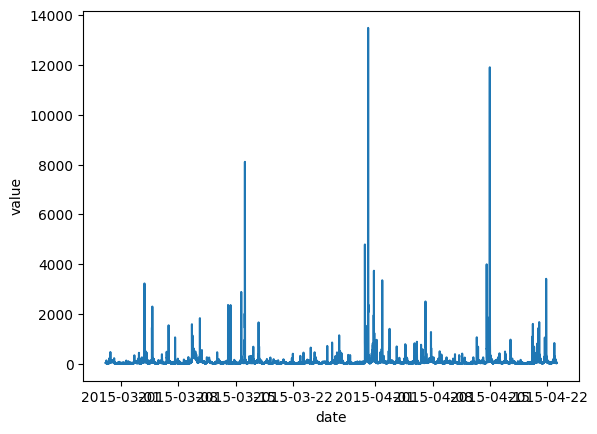

In [6]:
sns.lineplot(data=train, x='date', y='value')

<AxesSubplot:xlabel='date', ylabel='predicted'>

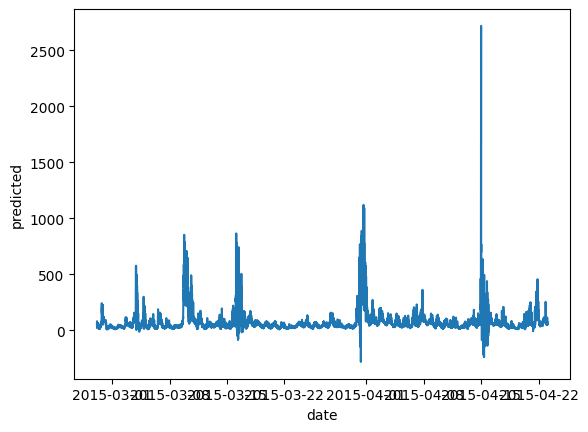

In [7]:
sns.lineplot(data=train, x='date', y='predicted')

In [8]:
def padding(arr, window, type_pad):
    pad_seq = None
    diff = window-len(arr)
    pad_seq = [0]*diff
    if type_pad == 'pre':
        pad_seq.extend(arr)
    else:
        arr.extend(pad_seq)
    return (pad_seq)

In [9]:
window = 10
arr_train = []
label = []
for index, row in train.iterrows(): 
    if row['is_anomaly']:
        label.append(1)
    else:
        label.append(0) 
        
    if window<index:
        seq = list(train.value[index-window:index])
        arr_train.append(seq)
    else:
        seq = (train.value[0:index])
        seq = padding(seq, window, "pre")
        arr_train.append(seq)

In [10]:
arr_train = np.array(arr_train)

In [11]:
arr_train.shape, len(label), arr_train[0].shape

((15830, 10), 15830, (10,))

In [12]:
arr_train[0].shape

(10,)

In [14]:
arr_train = arr_train.reshape(15830, 1, 10)

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [16]:
model = keras.Sequential()

Metal device set to: Apple M1


2022-11-03 12:07:16.316655: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-03 12:07:16.316926: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
model = keras.Sequential()
model.add(layers.LSTM(64, input_shape=arr_train.shape[1:], return_sequences=True))
#model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation="sigmoid"))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             19200     
                                                                 
 dense (Dense)               (None, 1, 1)              65        
                                                                 
Total params: 19,265
Trainable params: 19,265
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
label = np.asarray(label).astype('float32').reshape((-1,1))

In [19]:
model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer="sgd",
    metrics=["accuracy"],
)

In [20]:
history = model.fit(arr_train, label, epochs=10, validation_data=(arr_train, label))

Epoch 1/10


2022-11-03 12:07:16.717753: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-03 12:07:17.376013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 12:07:17.532182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 12:07:17.758225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


495/495 [==============================] - ETA: 0s - loss: 0.1944 - accuracy: 0.9497

2022-11-03 12:07:24.843519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 12:07:24.908312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


495/495 [==============================] - 11s 20ms/step - loss: 0.1944 - accuracy: 0.9497 - val_loss: 0.1853 - val_accuracy: 0.9510
Epoch 2/10
495/495 [==============================] - 9s 19ms/step - loss: 0.1841 - accuracy: 0.9510 - val_loss: 0.1829 - val_accuracy: 0.9510
Epoch 3/10
495/495 [==============================] - 10s 19ms/step - loss: 0.1835 - accuracy: 0.9510 - val_loss: 0.1816 - val_accuracy: 0.9510
Epoch 4/10
495/495 [==============================] - 10s 19ms/step - loss: 0.1825 - accuracy: 0.9510 - val_loss: 0.1810 - val_accuracy: 0.9510
Epoch 5/10
495/495 [==============================] - 10s 19ms/step - loss: 0.1807 - accuracy: 0.9508 - val_loss: 0.1808 - val_accuracy: 0.9510
Epoch 6/10
495/495 [==============================] - 10s 19ms/step - loss: 0.1800 - accuracy: 0.9515 - val_loss: 0.1784 - val_accuracy: 0.9521
Epoch 7/10
495/495 [==============================] - 11s 23ms/step - loss: 0.1793 - accuracy: 0.9519 - val_loss: 0.1791 - val_accuracy: 0.9514
Epoc

In [21]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

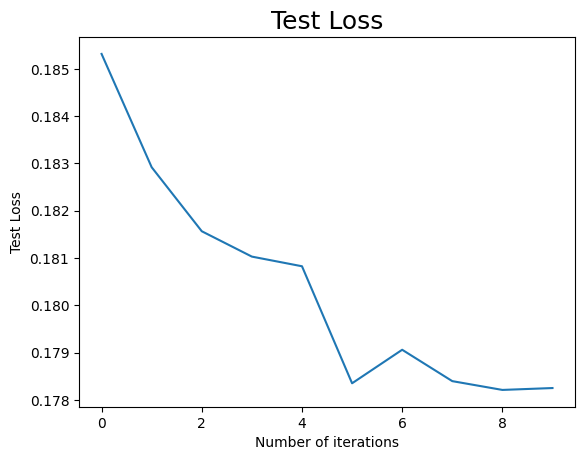

In [22]:
import matplotlib.pyplot as plt
#visualizing the change in the validation loss
plt.plot(val_loss) 
plt.title("Test Loss",size=18)
plt.xlabel("Number of iterations") 
plt.ylabel("Test Loss") 
plt.show() 

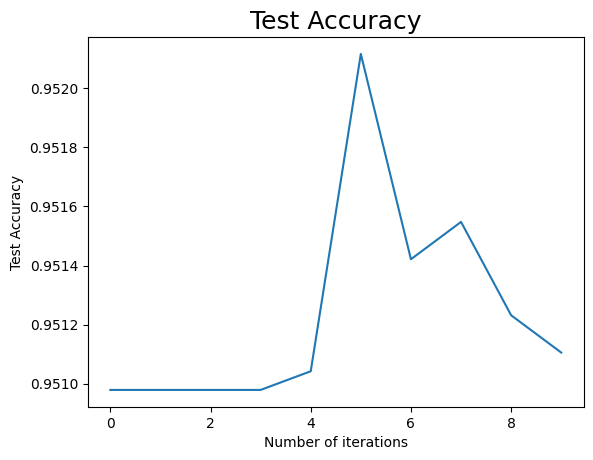

In [23]:
import matplotlib.pyplot as plt
#visualizing the change in the validation loss
plt.plot(val_acc) 
plt.title("Test Accuracy",size=18)
plt.xlabel("Number of iterations") 
plt.ylabel("Test Accuracy") 
plt.show() 

In [24]:
test.head()

,timestamp,value,predicted
0,1396332000,20.0,20.0
1,1396332300,20.0,20.0
2,1396332600,20.0,20.0
3,1396332900,20.0,20.0
4,1396333200,20.0,20.0


In [25]:
test['date'] = pd.to_datetime(test['timestamp'],unit='s')
test.head(10)

,timestamp,value,predicted,date
0,1396332000,20.0,20.0,2014-04-01 06:00:00
1,1396332300,20.0,20.0,2014-04-01 06:05:00
2,1396332600,20.0,20.0,2014-04-01 06:10:00
3,1396332900,20.0,20.0,2014-04-01 06:15:00
4,1396333200,20.0,20.0,2014-04-01 06:20:00
5,1396333500,20.0,20.0,2014-04-01 06:25:00
6,1396333800,20.0,20.0,2014-04-01 06:30:00
7,1396334100,20.0,20.0,2014-04-01 06:35:00
8,1396334400,20.0,20.0,2014-04-01 06:40:00
9,1396334700,20.0,20.0,2014-04-01 06:45:00


<AxesSubplot:xlabel='date', ylabel='value'>

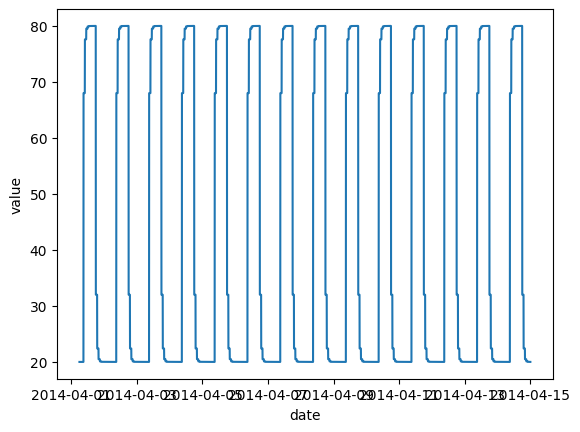

In [26]:
sns.lineplot(data=test, x="date", y="value")

In [27]:
window = 10
arr_test = []
for index, row in test.iterrows(): 
    if window<index:
        seq = list(test.value[index-window:index])
        arr_test.append(seq)
    else:
        seq = (test.value[0:index])
        seq = padding(seq, window, "pre")
        arr_test.append(seq)

In [28]:
arr_test = np.array(arr_test)
arr_test.shape

(3960, 10)

In [29]:
arr_test = arr_test.reshape(3960, 1, 10)

In [30]:
arr_test.shape

(3960, 1, 10)

In [31]:
prediction = model.predict(arr_test)

 12/124 [=>............................] - ETA: 0s 

2022-11-03 12:08:58.690274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 12:08:58.733978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


124/124 [==============================] - 1s 5ms/step


In [32]:
prediction.shape

(3960, 1, 1)

In [33]:
prediction.flatten()

array([0.47281426, 0.4089237 , 0.41136566, ..., 0.03841278, 0.03841174,
       0.03841174], dtype=float32)

In [34]:
prediction = [1 if x>0.5 else 0 for x in prediction]
is_anomaly = [True if x==1 else False for x in prediction]

In [35]:
test['is_anomaly'] = is_anomaly
test.head()

,timestamp,value,predicted,date,is_anomaly
0,1396332000,20.0,20.0,2014-04-01 06:00:00,False
1,1396332300,20.0,20.0,2014-04-01 06:05:00,False
2,1396332600,20.0,20.0,2014-04-01 06:10:00,False
3,1396332900,20.0,20.0,2014-04-01 06:15:00,False
4,1396333200,20.0,20.0,2014-04-01 06:20:00,False


In [37]:
test[['timestamp', 'is_anomaly']].to_csv('g_submission.csv', index=False)